# Imports and modules

In [1]:
import os
import requests
import pandas as pd
import time 
import numpy as np
import pytz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import descartes
import geopandas as gpd

from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate
from scipy.stats import randint
from sklearn import svm
from sklearn.feature_selection import r_regression
from sklearn.neighbors import KNeighborsClassifier
from shapely.geometry import Point, Polygon

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Extract from CSV and Preprocessing

## Function to extract data from CSV

In [2]:
def get_data(path, file_names):
    tables=[]
    for file_name in file_names:
        table = pd.read_csv(f'../{path}/{file_name}.csv')
        table['type']=f'{file_name}'
        tables.append(table)
    return pd.concat(tables)

path='data/raw_data'
file_names = ['trawlers', 'drifting_longlines', 'fixed_gear', 'pole_and_line', 'purse_seines', 'trollers', 'unknown']

df = get_data(path, file_names)

df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,type
0,1.252340e+12,1.325376e+09,0.0,0.0,0.0,153.0,52.458649,4.581200,-1.0,gfw,trawlers
1,1.252340e+12,1.325378e+09,0.0,0.0,0.0,153.0,52.458668,4.581167,-1.0,gfw,trawlers
2,1.252340e+12,1.325379e+09,0.0,0.0,0.0,153.0,52.458633,4.581183,-1.0,gfw,trawlers
3,1.252340e+12,1.325380e+09,0.0,0.0,0.0,153.0,52.458649,4.581234,-1.0,gfw,trawlers
4,1.252340e+12,1.325381e+09,0.0,0.0,0.0,153.0,52.458649,4.581183,-1.0,gfw,trawlers


In [3]:
df['mmsi'].nunique()

354

## Remove unknown (-1 in is_fishing column)

In [4]:
df = df.loc[df['is_fishing'] > -1]

In [5]:
df['is_fishing'].value_counts()

0.000000    295979
1.000000    247498
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: is_fishing, dtype: int64

## OHE 'type'

In [6]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df[['type']])

# Transform the current "Alley" column
df[ohe.get_feature_names_out()] = ohe.transform(df[['type']])

# Drop the column "Alley" which has been encoded
df.drop(columns = ["type", "source"], inplace = True)

## Converting is_fishing to Binary (0 or 1)

In [7]:
df_fishing = df
df_fishing['is_fishing'].value_counts()

0.000000    295979
1.000000    247498
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: is_fishing, dtype: int64

In [8]:
# round the decimals so that number becomes 0 or 1
df_fishing.loc[:, ('is_fishing')] = round(df_fishing.loc[:, ('is_fishing')])

In [9]:
# check the unique values
df_fishing['is_fishing'].value_counts()

0.0    300766
1.0    253089
Name: is_fishing, dtype: int64

In [10]:
df_fishing.head(3)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,1.420089e+09,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60648,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Date Engineering

## Converting timestamp to datetime format

In [11]:
df_fishing['timestamp'] = pd.to_datetime(df_fishing['timestamp'], unit='s')
df_fishing.head(2)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
df_fishing.rename(columns={"timestamp": "date"}, inplace=True)
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
df_fishing['year'] = df_fishing['date'].dt.year
# 12 columns for month
df_fishing['month'] = df_fishing['date'].dt.month
#df_fishing['day'] = df_fishing['date'].dt.day
# 7 columns for days
df_fishing['day_of_week'] = df_fishing['date'].dt.day_of_week
#df_fishing['day_of_year'] = df_fishing['date'].dt.day_of_year
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3


## Using Angular distance for the days of the week

In [14]:
df_fishing['day_of_week_sin'] = np.sin(df_fishing['day_of_week'] * (2 * np.pi / 7))
df_fishing['day_of_week_cos'] = np.cos(df_fishing['day_of_week'] * (2 * np.pi / 7))
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week,day_of_week_sin,day_of_week_cos
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969


## UTC converter

In [15]:
def get_utc_offset_from_longitude(longitude):
    timezone = pytz.timezone(pytz.country_timezones("US")[0])  # You can replace "US" with the appropriate country code
    now = datetime.now(timezone)
    utc_offset = now.utcoffset().total_seconds() / 3600
    return utc_offset

df_fishing['utc_offset'] = df_fishing['lon'].apply(get_utc_offset_from_longitude)
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week,day_of_week_sin,day_of_week_cos,utc_offset
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,...,0.0,1.0,0.0,0.0,2015,1,3,0.433884,-0.900969,-4.0


## Encoding dates

In [16]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df_fishing[['day_of_week']])

# Transform the current "Alley" column
df_fishing[ohe.get_feature_names_out()] = ohe.transform(df_fishing[['day_of_week']])

# Drop the column "Alley" which has been encoded
df_fishing.drop(columns = ["day_of_week"], inplace = True)

In [17]:
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,day_of_week_sin,day_of_week_cos,utc_offset,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
df_fishing.isna().sum()

mmsi                       0
date                       0
distance_from_shore        0
distance_from_port         0
speed                      2
course                     2
lat                        0
lon                        0
is_fishing                 0
type_drifting_longlines    0
type_fixed_gear            0
type_pole_and_line         0
type_purse_seines          0
type_trawlers              0
type_trollers              0
type_unknown               0
year                       0
month                      0
day_of_week_sin            0
day_of_week_cos            0
utc_offset                 0
day_of_week_0              0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
dtype: int64

In [19]:
# Calculate the value counts of 'mmsi'
mmsi_counts = df_fishing['mmsi'].value_counts()

# Create a boolean mask for filtering mmsi values with counts less than or equal to 20
mask = mmsi_counts > 20

# Get the mmsi values that meet the condition
selected_mmsi = mmsi_counts[mask].index

# Use the isin() method to filter the DataFrame based on selected_mmsi
filtered_fishing_df = df_fishing[df_fishing['mmsi'].isin(selected_mmsi)]
filtered_fishing_df.nunique()

mmsi                          276
date                       545599
distance_from_shore         79297
distance_from_port          95687
speed                         240
course                       3602
lat                        363029
lon                        372401
is_fishing                      2
type_drifting_longlines         2
type_fixed_gear                 2
type_pole_and_line              2
type_purse_seines               2
type_trawlers                   2
type_trollers                   2
type_unknown                    2
year                            5
month                          12
day_of_week_sin                 7
day_of_week_cos                 7
utc_offset                      1
day_of_week_0                   2
day_of_week_1                   2
day_of_week_2                   2
day_of_week_3                   2
day_of_week_4                   2
day_of_week_5                   2
day_of_week_6                   2
dtype: int64

## Defining X features and y target

In [20]:
df_fishing.isna().sum()

mmsi                       0
date                       0
distance_from_shore        0
distance_from_port         0
speed                      2
course                     2
lat                        0
lon                        0
is_fishing                 0
type_drifting_longlines    0
type_fixed_gear            0
type_pole_and_line         0
type_purse_seines          0
type_trawlers              0
type_trollers              0
type_unknown               0
year                       0
month                      0
day_of_week_sin            0
day_of_week_cos            0
utc_offset                 0
day_of_week_0              0
day_of_week_1              0
day_of_week_2              0
day_of_week_3              0
day_of_week_4              0
day_of_week_5              0
day_of_week_6              0
dtype: int64

In [21]:
# Dropping rows with NAN values
df_fishing_clean = df_fishing.dropna()

In [22]:
df_fishing_clean

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,day_of_week_sin,day_of_week_cos,utc_offset,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.000000,0.0,128.000000,52.458717,4.581316,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.000000,0.0,128.000000,52.458733,4.581316,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.000000,0.0,128.000000,52.458698,4.581267,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.000000,0.0,128.000000,52.458698,4.581234,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.000000,0.0,128.000000,52.458683,4.581183,0.0,0.0,...,0.433884,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806717,2.698965e+14,2015-12-29 14:29:51,0.0,55071.328125,0.0,0.000000,43.310925,13.734748,1.0,0.0,...,0.781831,0.623490,-4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6806718,2.698965e+14,2015-12-29 14:46:08,0.0,55071.328125,0.0,0.000000,43.310932,13.734747,1.0,0.0,...,0.781831,0.623490,-4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6806719,2.698965e+14,2015-12-29 15:02:30,0.0,55071.328125,0.0,0.000000,43.310944,13.734741,1.0,0.0,...,0.781831,0.623490,-4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6806720,2.698965e+14,2015-12-29 15:18:29,0.0,55071.328125,0.0,0.000000,43.310955,13.734722,1.0,0.0,...,0.781831,0.623490,-4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df_fishing_clean.shape

(553853, 28)

# Defining X - Features and y - Target

In [24]:
# Defining X - the features and Y - the target
X = df_fishing_clean.drop(columns=['mmsi','date', 'is_fishing', 'utc_offset'])
y = df_fishing_clean['is_fishing']

In [25]:
X.shape

(553853, 24)

In [26]:
y.shape

(553853,)

# Correlation

## Pearson correlation

In [27]:
corr = r_regression(X, y)
col_names = list(X.columns)
df_corr = pd.DataFrame(corr, col_names)
df_corr

,0
distance_from_shore,0.351586
distance_from_port,0.382767
speed,0.180394
course,-0.017665
lat,-0.179662
lon,-0.055053
type_drifting_longlines,0.288469
type_fixed_gear,-0.108185
type_pole_and_line,-0.044696
type_purse_seines,-0.137088


## Heatmap

In [28]:
data = df_fishing_clean.drop(columns=['date', 'utc_offset'])

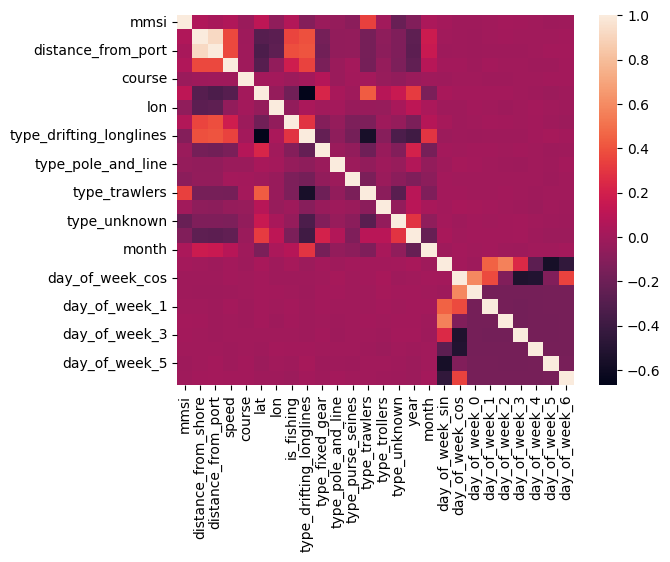

In [29]:
# plotting correlation heatmap
dataplot=sns.heatmap(data.corr())
  
# displaying heatmap
plt.show()

# Split between train set and test set

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

# Standard scaler

In [31]:
# Step 0 - Instantiate and fit Standard Scaler
scaler = StandardScaler()
scaler.fit(X_train)

# Step 1 - Scale/Transform
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
data_clean = df_fishing_clean.drop(columns=['date', 'utc_offset'])
data_clean.head()

,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,...,month,day_of_week_sin,day_of_week_cos,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
60646,1.252340e+12,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,...,1,0.433884,-0.900969,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60647,1.252340e+12,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,...,1,0.433884,-0.900969,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60648,1.252340e+12,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,...,1,0.433884,-0.900969,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60649,1.252340e+12,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,...,1,0.433884,-0.900969,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60650,1.252340e+12,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,...,1,0.433884,-0.900969,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
fishing = data_clean[data_clean['is_fishing']==1]

In [ ]:
# Defining X - the features and Y - the target
X_f = fishing.drop(columns=['mmsi','date', 'is_fishing', 'utc_offset'])
y_f = fishing['is_fishing']

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit it to the target
label_encoder.fit(target) # If in dataframe df['target']

# Transform the targets
encoded_target = label_encoder.transform(target) # If in dataframe df['target']

# Boat classification

In [32]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [33]:
y_pred = classifier.predict(X_test)
classifier.score(X_train_scaled,y_train)

0.9977946695486424

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.53      0.70      0.60     90339
         1.0       0.42      0.26      0.32     75817

    accuracy                           0.50    166156
   macro avg       0.48      0.48      0.46    166156
weighted avg       0.48      0.50      0.47    166156



# Logistic Regresssion

In [33]:
model = LogisticRegression(max_iter=1000).fit(X_train_scaled,y_train)

# Score the model
# LogisticRegression will default scoring to accuracy.
model.score(X_train_scaled,y_train)

0.7085584876849704

In [34]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75     90339
         1.0       0.73      0.56      0.64     75817

    accuracy                           0.71    166156
   macro avg       0.71      0.69      0.69    166156
weighted avg       0.71      0.71      0.70    166156



In [55]:
cv_lr_results = cross_validate(model,
                            X_test_scaled, 
                            y_test, 
                            cv=5,
                            scoring =['accuracy'])
cv_lr_results

{'fit_time': array([0.22796297, 0.20096803, 0.29964614, 0.30657196, 0.29179692]),
 'score_time': array([0.00566506, 0.00549793, 0.00627685, 0.00680518, 0.0043118 ]),
 'test_accuracy': array([0.70708955, 0.70425205, 0.70560621, 0.7048539 , 0.70831453])}

In [56]:
cv_lr_results['test_accuracy'].mean()

0.706023248836615

# KNN Classifier

In [35]:
# Instanciate the model
# n_neighbors=5 (default)
knn_model = KNeighborsClassifier(n_neighbors=3).fit(X_train_scaled, y_train)

In [36]:
y_pred = knn_model.predict(X_test_scaled)

In [37]:
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.9528756108717109

In [38]:
precision = precision_score(y_test, y_pred)
precision

0.9480433894373345

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     90339
         1.0       0.95      0.95      0.95     75817

    accuracy                           0.95    166156
   macro avg       0.95      0.95      0.95    166156
weighted avg       0.95      0.95      0.95    166156



In [57]:
cv_knn_results = cross_validate(knn_model,
                            X_test_scaled, 
                            y_test, 
                            cv=5,
                            scoring =['accuracy'])
cv_knn_results

{'fit_time': array([0.02828789, 0.03039479, 0.03116488, 0.02066588, 0.03161716]),
 'score_time': array([7.96783638, 7.72179294, 7.27718401, 7.22355199, 6.98397112]),
 'test_accuracy': array([0.93066923, 0.92982456, 0.92798893, 0.93060696, 0.93057687])}

In [58]:
cv_knn_results['test_accuracy'].mean()

0.9299333112501312

# Random forest

In [40]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [41]:
y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9772864055465947


In [42]:
precision = precision_score(y_test, y_pred)
print(f"Precision:{precision:.2f}")

Precision:0.97


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     90339
         1.0       0.97      0.98      0.98     75817

    accuracy                           0.98    166156
   macro avg       0.98      0.98      0.98    166156
weighted avg       0.98      0.98      0.98    166156



In [44]:
cv_results = cross_validate(rf,
                            X_test_scaled, 
                            y_test, 
                            cv=5,
                            scoring =['accuracy'])
cv_results

{'fit_time': array([19.52268195, 19.25995994, 18.91368699, 19.43807101, 19.04131603]),
 'score_time': array([0.63597989, 0.63196707, 0.63555312, 0.63685799, 0.63239717]),
 'test_accuracy': array([0.96668873, 0.96476182, 0.96343775, 0.96328729, 0.96488219])}

In [45]:
cv_results['test_accuracy'].mean()

0.9646115573486579

# Export to CSV for quick access

In [46]:
output_folder = '../data/preprocessed'
output_file = 'preproc.csv'

# Construct the full path
output_path = f'{output_folder}/{output_file}'

# Save the DataFrame to the specified path
df_fishing.to_csv(output_path, index=False)

# Map data on world map with geopandas

In [47]:
geometry = [Point(xy) for xy in zip(df_fishing['lon'], df_fishing['lat'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df_fishing, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,day_of_week_cos,utc_offset,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,geometry
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,...,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,POINT (4.58132 52.45872)
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,...,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,POINT (4.58132 52.45873)
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,...,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,POINT (4.58127 52.45870)
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,...,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,POINT (4.58123 52.45870)
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,...,-0.900969,-4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,POINT (4.58118 52.45868)


## Mapping one boat

In [48]:
boat = geo_df._get_value(60649, 'mmsi')
one_boat = geo_df.loc[geo_df['mmsi']== boat]

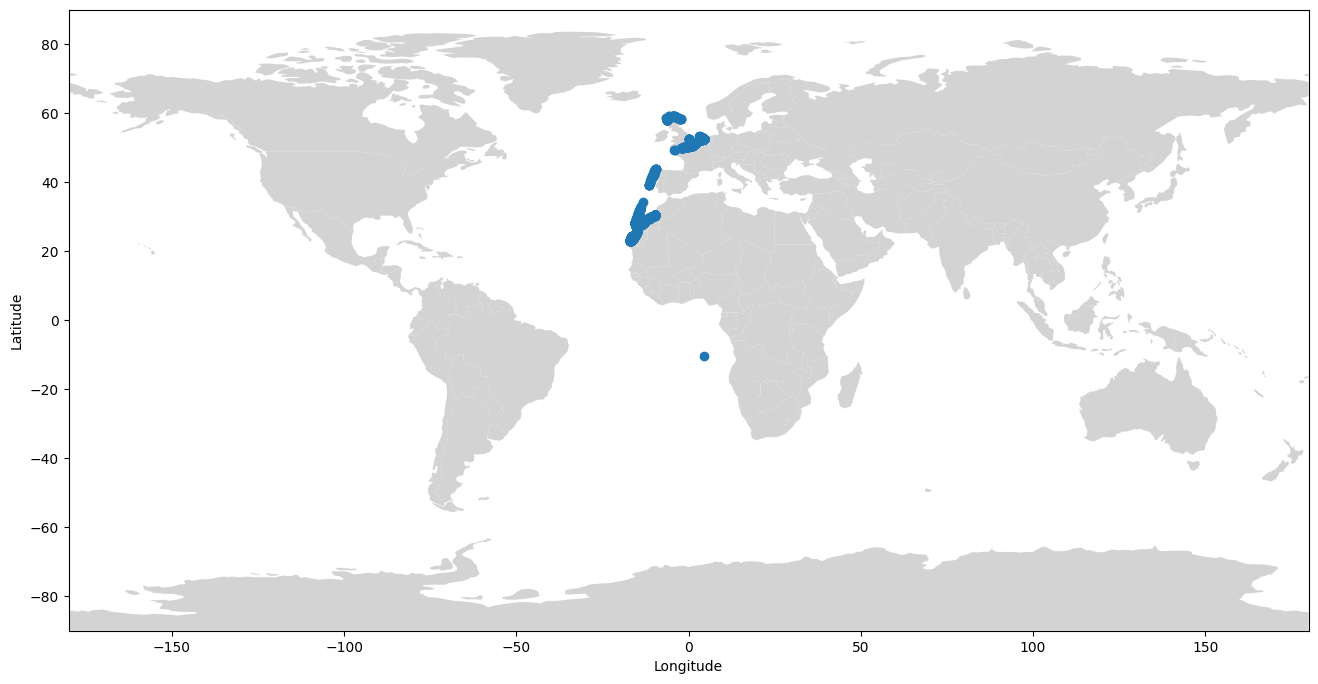

In [49]:
# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = one_boat['lon']
y = one_boat['lat']
plt.scatter(x, y, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Mapping all boats

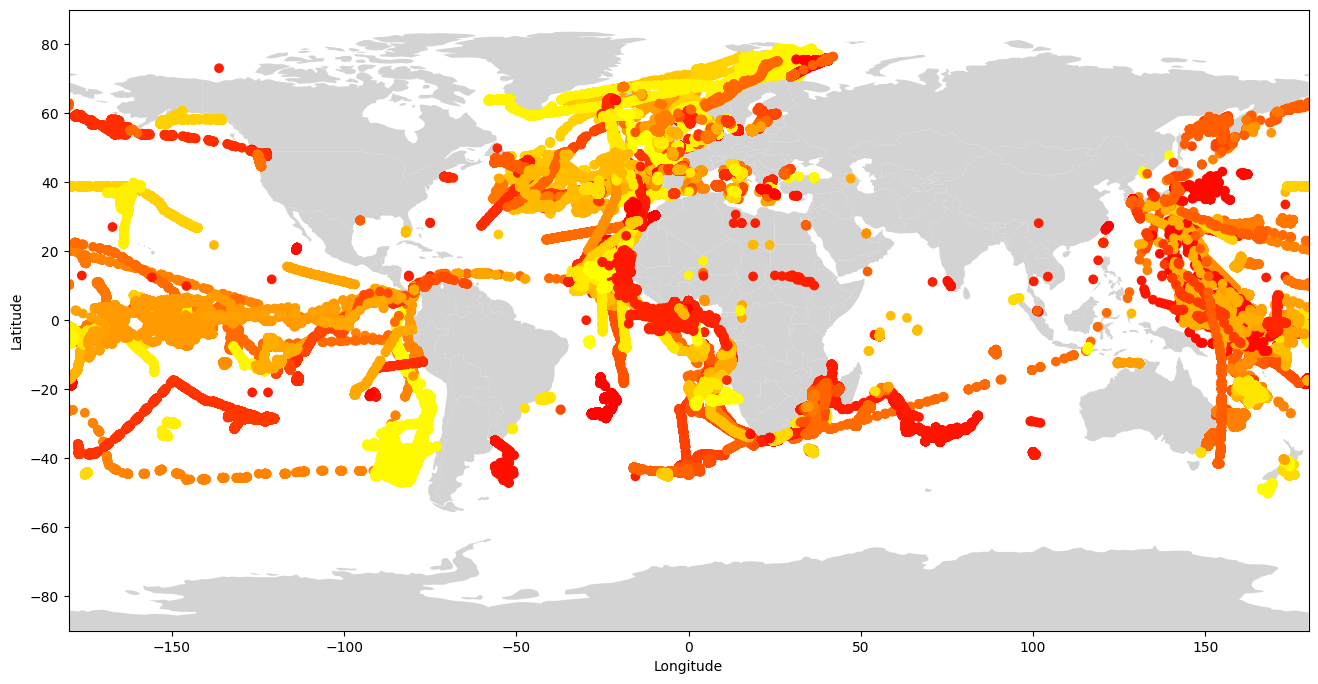

In [50]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = geo_df['lon']
y = geo_df['lat']
boats = geo_df['mmsi']
plt.scatter(x, y, c=boats, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [51]:
df_fishing_clean.shape

(553853, 28)

In [52]:
df_fishing_clean['is_fishing'].value_counts()

is_fishing
0.0    300765
1.0    253088
Name: count, dtype: int64

In [53]:
grouped = df_fishing_clean.groupby('mmsi')

In [54]:
grouped['is_fishing'].value_counts()

mmsi          is_fishing
1.252340e+12  0.0           3209
              1.0            273
1.272260e+12  0.0             20
1.679642e+12  0.0           1514
              1.0           1358
                            ... 
2.802913e+14  0.0            194
              1.0            194
2.810605e+14  0.0             34
2.812058e+14  1.0           2104
              0.0            151
Name: count, Length: 583, dtype: int64